In [93]:
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers.legacy import Adam
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.layers as kl
import os

# Load the CSV files containing image labels
train_df = pd.read_csv('../Dataset/Labels/TrainLabels.csv')
test_df = pd.read_csv('../Dataset/Labels/TestLabels.csv')
validation_df = pd.read_csv('../Dataset/Labels/ValidationLabels.csv')

In [94]:
def graphs(history):
    #Accuracy graph
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper left')
    plt.show()

    #Loss graph
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.show()

def augment_image(image):
    # Mirror flip
    # black_white = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    flipped = tf.image.flip_left_right(image)
    # Transpose flip
    transposed = tf.image.transpose(image)
    # Saturation
    saturated = tf.image.adjust_saturation(flipped, 3)
    # Brightness
    brightness = tf.image.adjust_brightness(saturated, 0.4)
    # Contrast
    contrast = tf.image.random_contrast(brightness, lower=0.0, upper=1.0)

    # Resize at the end
    # images = [flipped, transposed, saturated, brightness, contrast]
    return contrast


def plot_images(images, labels, title):
    plt.figure(figsize=(10, 10))
    for i in range(min(len(images), 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.suptitle(title)
    plt.show()


def normalize_class_values(df):
    classes = ['Boredom', 'Engagement', 'Confusion', 'Frustration']
    max_possible_value = 3

    # for index, row in df.iterrows():
    #     if row['Boredom'] == 1:
    #         df.at[index, 'Engagement'] = 2
    #     elif row['Boredom'] > 1:
    #         df.at[index, 'Engagement'] = 1
    # 
    #     if row['Frustration'] == 1:
    #         df.at[index, 'Frustration'] = 2
    #     elif row['Frustration'] == 2:
    #         df.at[index, 'Frustration'] = 3
    # 
    #     if row['Confusion'] == 1:
    #         df.at[index, 'Confusion'] = 2
    #     elif row['Confusion'] == 2:
    #         df.at[index, 'Confusion'] = 3
            
        # if row['Frustration'] > 30 or row['Confusion'] > 0 or row['Boredom'] > 0:
        #     df.at[index, 'Engagement'] = 1
            

    for class_name in classes:
        df[class_name] = round(df[class_name] / max_possible_value, 1)  # Round to 1 decimal place

    return df


# Update the 'ClipID' column in the CSV files to include the full path to each frame
def generate_full_paths(row, dataset_dir):
    video_name = row['ClipID'].strip()  # Remove any leading or trailing whitespaces
    full_paths = [os.path.join(dataset_dir, f'{video_name[:-4]}{i}.jpg') for i in range(1, 10)]
    return full_paths


def model():
    model = tf.keras.Sequential()
    model.add(kl.InputLayer(input_shape=(80, 144, 3)))
    
    # Convolutional layers with increased filters and kernel size
    model.add(kl.Conv2D(filters=128, kernel_size=3, padding='same', strides=2))
    model.add(kl.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.3))
    
    model.add(kl.Conv2D(filters=256, kernel_size=3, padding='same', strides=2))
    model.add(kl.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.4))
    
    model.add(kl.Conv2D(filters=512, kernel_size=3, padding='same', strides=2))
    model.add(kl.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(kl.MaxPooling2D(pool_size=(2, 2)))
    model.add(kl.Dropout(0.4))

    # model.add(kl.Conv2D(filters=1024, kernel_size=3, padding='same', strides=2))
    # model.add(kl.BatchNormalization())
    # model.add(tf.keras.layers.ReLU())
    # model.add(kl.MaxPooling2D(pool_size=(1, 1)))
    # model.add(kl.Dropout(0.4))
    
    # Flatten and fully connected layers with increased neurons
    model.add(kl.Flatten())
    model.add(kl.Dense(1024))
    model.add(kl.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(kl.Dropout(0.5))
    
    model.add(kl.Dense(512))
    model.add(kl.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(kl.Dropout(0.5))
    
    # Output layer with softmax activation
    model.add(kl.Dense(4, activation='softmax', name='prediction'))
    
    return model


def saveModelWeights(model, test_acc):
    # Serialize and save model to JSON
    model_name = f'model_{test_acc:.4f}'
    model_json = model.to_json()
    with open(f'{model_name}.json', 'w') as json_file:
        json_file.write(model_json)
    # Save weights to JSON
    model.save_weights(f'{model_name}.h5')

In [95]:
# Load the CSV files containing image labels
train_df = pd.read_csv('../Dataset/Labels/TrainLabels.csv')
test_df = pd.read_csv('../Dataset/Labels/TestLabels.csv')
validation_df = pd.read_csv('../Dataset/Labels/ValidationLabels.csv')

# Specify K for KFold cross-validation
kfold = KFold(n_splits=10, shuffle=True)

# Define image data generators for training, testing, and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
)
validation_datagen = ImageDataGenerator(
    rescale=1./255,
)

# Construct paths for each dataset
train_df['ClipID'] = train_df.apply(lambda row: generate_full_paths(row, '../Dataset/Image_Dataset_3/Train/face_mesh_rois_vertical'), axis=1)
test_df['ClipID'] = test_df.apply(lambda row: generate_full_paths(row, '../Dataset/Image_Dataset_3/Test/face_mesh_rois_vertical'), axis=1)
validation_df['ClipID'] = validation_df.apply(
    lambda row: generate_full_paths(row, '../Dataset/Image_Dataset_3/Validation/face_mesh_rois_vertical'), axis=1)

# Flatten the DataFrame to have one row per frame
train_df = train_df.explode('ClipID').reset_index(drop=True)
test_df = test_df.explode('ClipID').reset_index(drop=True)
validation_df = validation_df.explode('ClipID').reset_index(drop=True)

train_df_normalized = normalize_class_values(train_df)
test_df_normalized = normalize_class_values(test_df)
validation_df_normalized = normalize_class_values(validation_df)

# print(train_df_normalized['Engagement'].to_string(index=False))

classes = ['Boredom', 'Engagement', 'Confusion', 'Frustration']

earlyStopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=False
)

lrScheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)

callbacks = [
    earlyStopping,
    lrScheduler,
]


Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_87 (Conv2D)          (None, 40, 72, 128)       3584      
                                                                 
 batch_normalization_15 (Ba  (None, 40, 72, 128)       512       
 tchNormalization)                                               
                                                                 
 re_lu_103 (ReLU)            (None, 40, 72, 128)       0         
                                                                 
 max_pooling2d_87 (MaxPooli  (None, 20, 36, 128)       0         
 ng2D)                                                           
                                                                 
 dropout_97 (Dropout)        (None, 20, 36, 128)       0         
                                                                 
 conv2d_88 (Conv2D)          (None, 10, 18, 256)     

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1949 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 222 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/100
648/648 [==============================] - 180s 267ms/step - loss: 0.4555 - accuracy: 0.7897 - val_loss: 0.4404 - val_accuracy: 0.8063 - lr: 1.0000e-04
Epoch 2/100
648/648 [==============================] - 152s 235ms/step - loss: 0.4319 - accuracy: 0.7990 - val_loss: 0.4401 - val_accuracy: 0.8063 - lr: 1.0000e-04
Epoch 3/100
648/648 [==============================] - 152s 235ms/step - loss: 0.4259 - accuracy: 0.7991 - val_loss: 0.4341 - val_accuracy: 0.8059 - lr: 1.0000e-04
Epoch 4/100
648/648 [==============================] - 152s 235ms/step - loss: 0.4218 - accuracy: 0.8011 - val_loss: 0.4285 - val_accuracy: 0.8079 - lr: 1.0000e-04
Epoch 5/100
648/648 [==============================] - 139s 215ms/step - loss: 0.4184 - accuracy: 0.8010 - val_loss: 0.4279 - val_accuracy: 0.8103 - lr: 1.0000e-04
Epoch 6/100
648/648 [==============================] - 139s 214ms/step - loss: 0.4159 - accuracy: 0.8031 - val_loss: 0.4294 - val_accuracy: 0.8150 - lr: 1.0000e-04
Epoch 7/100
648/

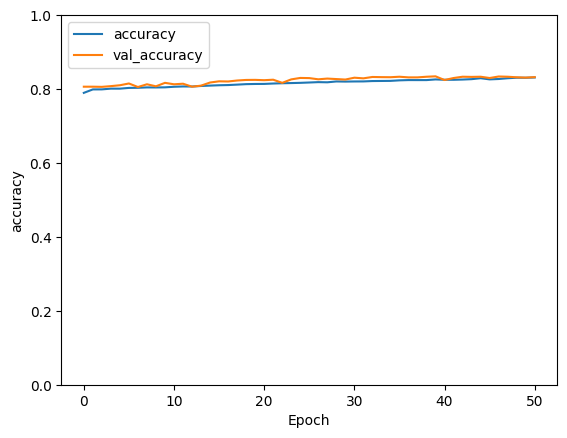

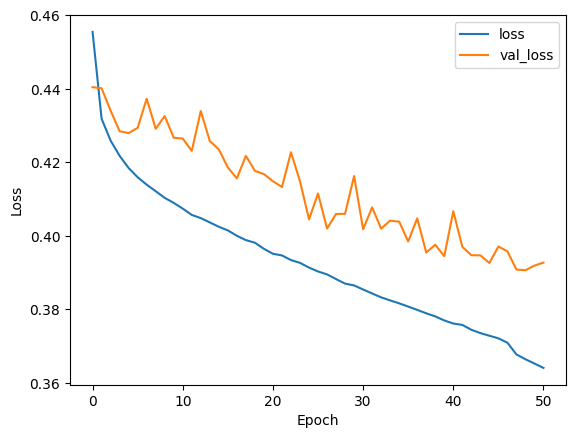

Training fold 2
Found 41455 validated image filenames.
Found 15430 validated image filenames.
Found 4596 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1944 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 227 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/100
648/648 [==============================] - 142s 219ms/step - loss: 0.3669 - accuracy: 0.8306 - val_loss: 0.3692 - val_accuracy: 0.8442 - lr: 5.0000e-05
Epoch 2/100
648/648 [==============================] - 139s 214ms/step - loss: 0.3661 - accuracy: 0.8306 - val_loss: 0.3683 - val_accuracy: 0.8449 - lr: 5.0000e-05
Epoch 3/100
648/648 [==============================] - 139s 215ms/step - loss: 0.3653 - accuracy: 0.8320 - val_loss: 0.3609 - val_accuracy: 0.8438 - lr: 5.0000e-05
Epoch 4/100
648/648 [==============================] - 139s 214ms/step - loss: 0.3647 - accuracy: 0.8317 - val_loss: 0.3618 - val_accuracy: 0.8473 - lr: 5.0000e-05
Epoch 5/100
648/648 [==============================] - 139s 214ms/step - loss: 0.3643 - accuracy: 0.8319 - val_loss: 0.3648 - val_accuracy: 0.8457 - lr: 5.0000e-05
Epoch 6/100
648/648 [==============================] - 139s 215ms/step - loss: 0.3635 - accuracy: 0.8313 - val_loss: 0.3718 - val_accuracy: 0.8457 - lr: 5.0000e-05
Epoch 7/100
648/

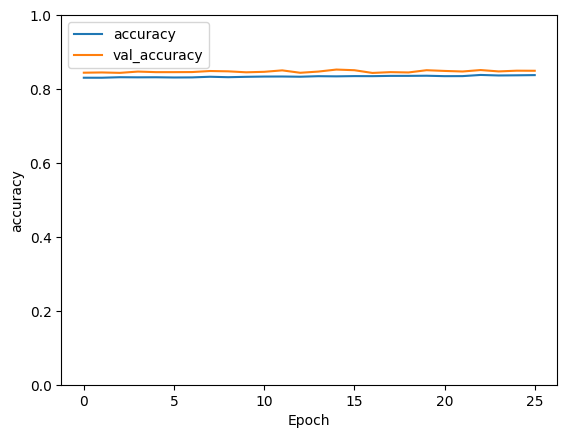

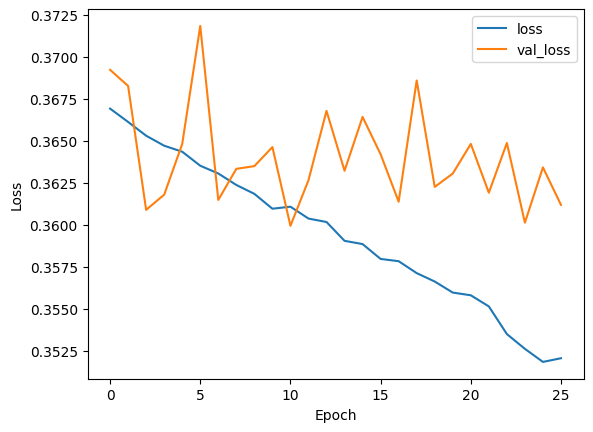

Training fold 3
Found 41456 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1944 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


Found 15430 validated image filenames.
Found 4595 validated image filenames.
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 227 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


648/648 [==============================] - 137s 212ms/step - loss: 0.3526 - accuracy: 0.8377 - val_loss: 0.3517 - val_accuracy: 0.8592 - lr: 2.5000e-05
Epoch 2/100
648/648 [==============================] - 122s 188ms/step - loss: 0.3527 - accuracy: 0.8369 - val_loss: 0.3490 - val_accuracy: 0.8607 - lr: 2.5000e-05
Epoch 3/100
648/648 [==============================] - 119s 183ms/step - loss: 0.3518 - accuracy: 0.8363 - val_loss: 0.3456 - val_accuracy: 0.8531 - lr: 2.5000e-05
Epoch 4/100
648/648 [==============================] - 117s 181ms/step - loss: 0.3516 - accuracy: 0.8370 - val_loss: 0.3469 - val_accuracy: 0.8572 - lr: 2.5000e-05
Epoch 5/100
648/648 [==============================] - 118s 182ms/step - loss: 0.3513 - accuracy: 0.8367 - val_loss: 0.3437 - val_accuracy: 0.8588 - lr: 2.5000e-05
Epoch 6/100
648/648 [==============================] - 118s 182ms/step - loss: 0.3511 - accuracy: 0.8380 - val_loss: 0.3463 - val_accuracy: 0.8540 - lr: 2.5000e-05
Epoch 7/100
648/648 [=======

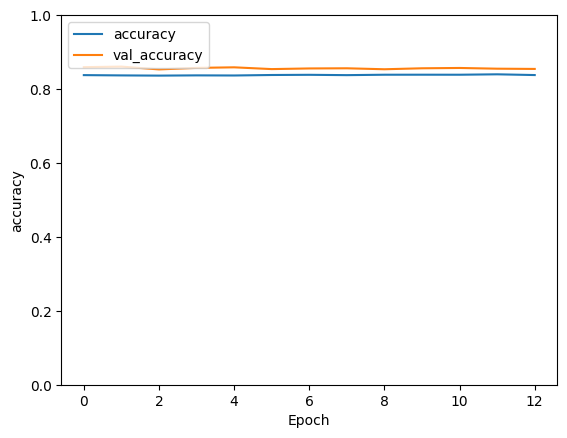

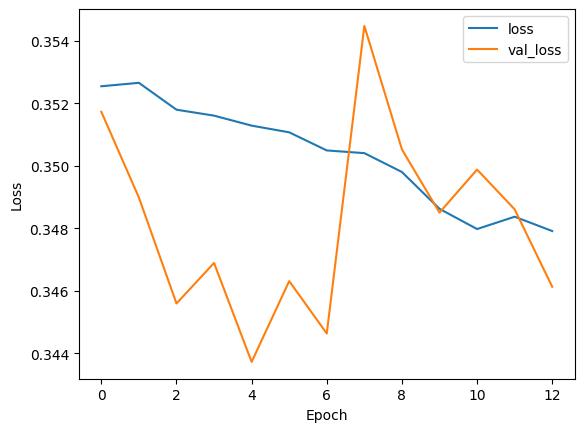

Training fold 4
Found 41441 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1959 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


Found 15430 validated image filenames.
Found 4610 validated image filenames.
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 212 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


648/648 [==============================] - 131s 203ms/step - loss: 0.3476 - accuracy: 0.8385 - val_loss: 0.3452 - val_accuracy: 0.8590 - lr: 1.2500e-05
Epoch 2/100
648/648 [==============================] - 120s 184ms/step - loss: 0.3476 - accuracy: 0.8381 - val_loss: 0.3482 - val_accuracy: 0.8594 - lr: 1.2500e-05
Epoch 3/100
648/648 [==============================] - 119s 184ms/step - loss: 0.3473 - accuracy: 0.8382 - val_loss: 0.3485 - val_accuracy: 0.8584 - lr: 1.2500e-05
Epoch 4/100
648/648 [==============================] - 119s 184ms/step - loss: 0.3470 - accuracy: 0.8393 - val_loss: 0.3478 - val_accuracy: 0.8573 - lr: 1.2500e-05
Epoch 5/100
648/648 [==============================] - 119s 184ms/step - loss: 0.3467 - accuracy: 0.8397 - val_loss: 0.3476 - val_accuracy: 0.8573 - lr: 1.2500e-05
Epoch 6/100
648/648 [==============================] - 119s 183ms/step - loss: 0.3466 - accuracy: 0.8396 - val_loss: 0.3476 - val_accuracy: 0.8594 - lr: 1.2500e-05
Epoch 7/100
648/648 [=======

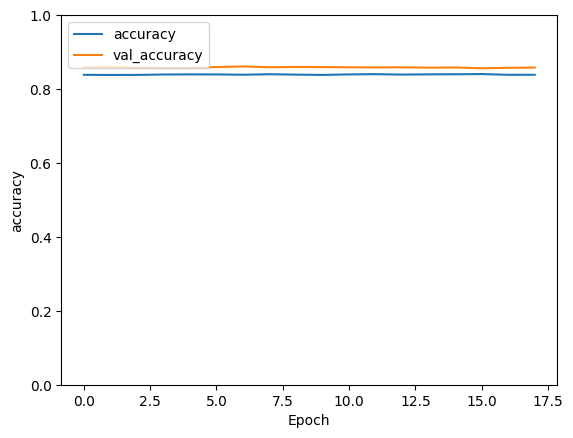

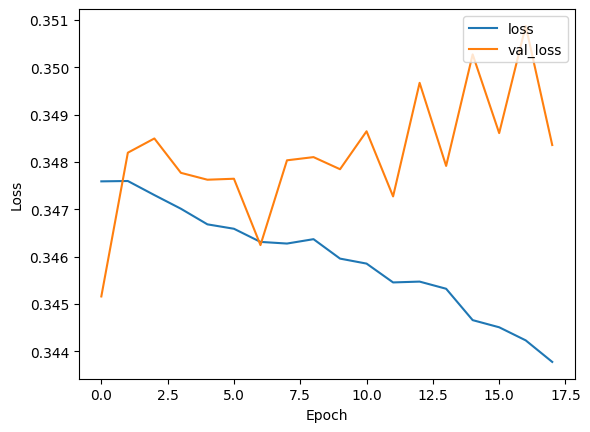

Training fold 5
Found 41442 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1958 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


Found 15430 validated image filenames.
Found 4609 validated image filenames.
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 213 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


648/648 [==============================] - 115s 177ms/step - loss: 0.3448 - accuracy: 0.8394 - val_loss: 0.3429 - val_accuracy: 0.8577 - lr: 6.2500e-06
Epoch 2/100
648/648 [==============================] - 112s 172ms/step - loss: 0.3447 - accuracy: 0.8410 - val_loss: 0.3442 - val_accuracy: 0.8568 - lr: 6.2500e-06
Epoch 3/100
648/648 [==============================] - 112s 172ms/step - loss: 0.3442 - accuracy: 0.8408 - val_loss: 0.3408 - val_accuracy: 0.8564 - lr: 6.2500e-06
Epoch 4/100
648/648 [==============================] - 110s 170ms/step - loss: 0.3443 - accuracy: 0.8410 - val_loss: 0.3434 - val_accuracy: 0.8551 - lr: 6.2500e-06
Epoch 5/100
648/648 [==============================] - 110s 170ms/step - loss: 0.3446 - accuracy: 0.8410 - val_loss: 0.3410 - val_accuracy: 0.8551 - lr: 6.2500e-06
Epoch 6/100
648/648 [==============================] - 110s 169ms/step - loss: 0.3443 - accuracy: 0.8401 - val_loss: 0.3429 - val_accuracy: 0.8544 - lr: 6.2500e-06
Epoch 7/100
648/648 [=======

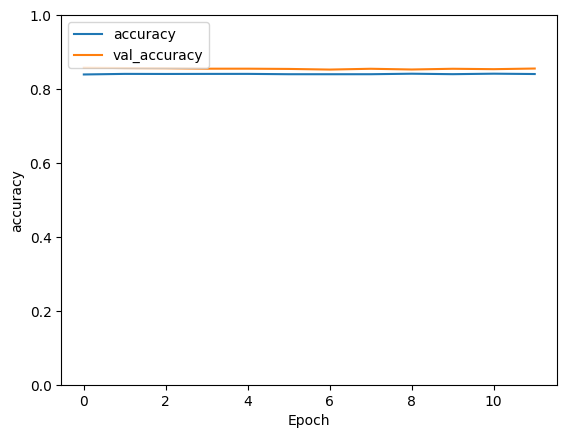

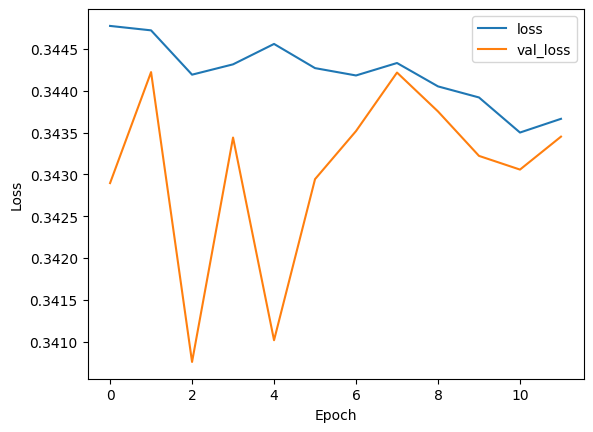

Training fold 6
Found 41463 validated image filenames.
Found 15430 validated image filenames.
Found 4588 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1937 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 234 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/100
648/648 [==============================] - 117s 180ms/step - loss: 0.3432 - accuracy: 0.8410 - val_loss: 0.3425 - val_accuracy: 0.8579 - lr: 3.1250e-06
Epoch 2/100
648/648 [==============================] - 114s 176ms/step - loss: 0.3434 - accuracy: 0.8400 - val_loss: 0.3432 - val_accuracy: 0.8581 - lr: 3.1250e-06
Epoch 3/100
648/648 [==============================] - 114s 176ms/step - loss: 0.3432 - accuracy: 0.8419 - val_loss: 0.3423 - val_accuracy: 0.8579 - lr: 3.1250e-06
Epoch 4/100
648/648 [==============================] - 114s 176ms/step - loss: 0.3433 - accuracy: 0.8418 - val_loss: 0.3422 - val_accuracy: 0.8588 - lr: 3.1250e-06
Epoch 5/100
648/648 [==============================] - 114s 175ms/step - loss: 0.3432 - accuracy: 0.8409 - val_loss: 0.3428 - val_accuracy: 0.8575 - lr: 3.1250e-06
Epoch 6/100
648/648 [==============================] - 113s 175ms/step - loss: 0.3430 - accuracy: 0.8423 - val_loss: 0.3427 - val_accuracy: 0.8575 - lr: 3.1250e-06
Epoch 7/100
648/

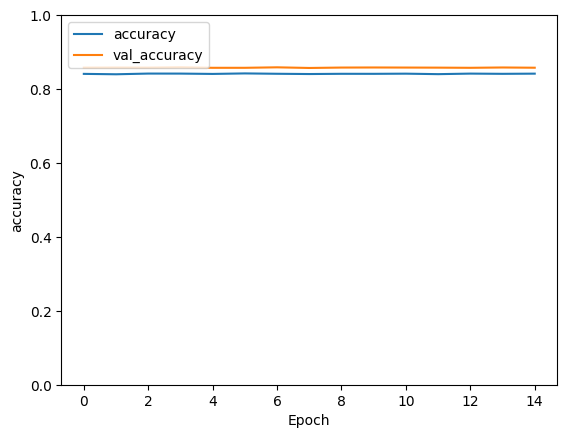

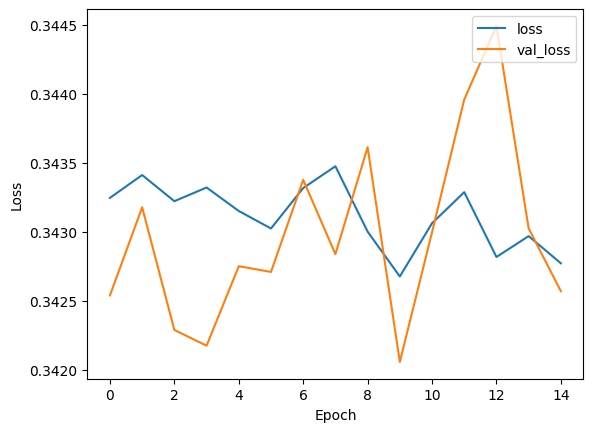

Training fold 7
Found 41441 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1959 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


Found 15430 validated image filenames.
Found 4610 validated image filenames.
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 212 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


648/648 [==============================] - 108s 167ms/step - loss: 0.3431 - accuracy: 0.8395 - val_loss: 0.3367 - val_accuracy: 0.8709 - lr: 1.5625e-06
Epoch 2/100
648/648 [==============================] - 107s 166ms/step - loss: 0.3433 - accuracy: 0.8398 - val_loss: 0.3374 - val_accuracy: 0.8694 - lr: 1.5625e-06
Epoch 3/100
648/648 [==============================] - 2231s 3s/step - loss: 0.3431 - accuracy: 0.8400 - val_loss: 0.3363 - val_accuracy: 0.8709 - lr: 1.5625e-06
Epoch 4/100
648/648 [==============================] - 148s 227ms/step - loss: 0.3430 - accuracy: 0.8405 - val_loss: 0.3371 - val_accuracy: 0.8705 - lr: 1.5625e-06
Epoch 5/100
648/648 [==============================] - 149s 230ms/step - loss: 0.3432 - accuracy: 0.8392 - val_loss: 0.3358 - val_accuracy: 0.8685 - lr: 1.5625e-06
Epoch 6/100
648/648 [==============================] - 147s 227ms/step - loss: 0.3429 - accuracy: 0.8410 - val_loss: 0.3376 - val_accuracy: 0.8707 - lr: 1.5625e-06
Epoch 7/100
648/648 [=========

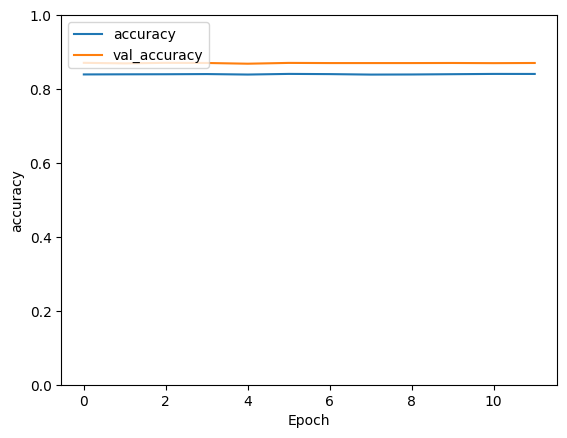

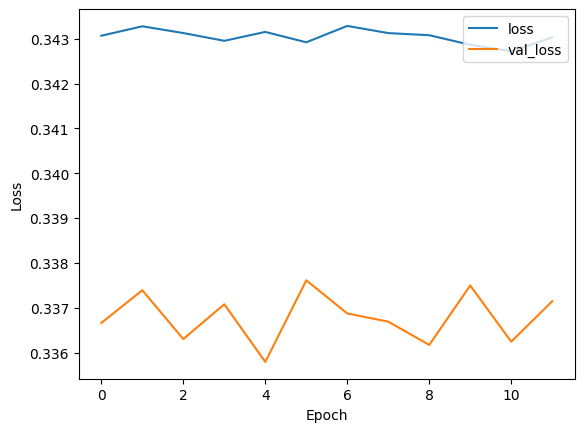

Training fold 8
Found 41429 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1971 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


Found 15430 validated image filenames.
Found 4622 validated image filenames.
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 200 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


648/648 [==============================] - 149s 230ms/step - loss: 0.3425 - accuracy: 0.8406 - val_loss: 0.3412 - val_accuracy: 0.8622 - lr: 7.8125e-07
Epoch 2/100
648/648 [==============================] - 145s 224ms/step - loss: 0.3426 - accuracy: 0.8407 - val_loss: 0.3423 - val_accuracy: 0.8630 - lr: 7.8125e-07
Epoch 3/100
648/648 [==============================] - 146s 225ms/step - loss: 0.3425 - accuracy: 0.8420 - val_loss: 0.3421 - val_accuracy: 0.8615 - lr: 7.8125e-07
Epoch 4/100
648/648 [==============================] - 146s 225ms/step - loss: 0.3422 - accuracy: 0.8414 - val_loss: 0.3416 - val_accuracy: 0.8624 - lr: 7.8125e-07
Epoch 5/100
648/648 [==============================] - 147s 226ms/step - loss: 0.3422 - accuracy: 0.8409 - val_loss: 0.3424 - val_accuracy: 0.8622 - lr: 7.8125e-07
Epoch 6/100
648/648 [==============================] - 146s 225ms/step - loss: 0.3426 - accuracy: 0.8430 - val_loss: 0.3424 - val_accuracy: 0.8628 - lr: 7.8125e-07
Epoch 7/100
648/648 [=======

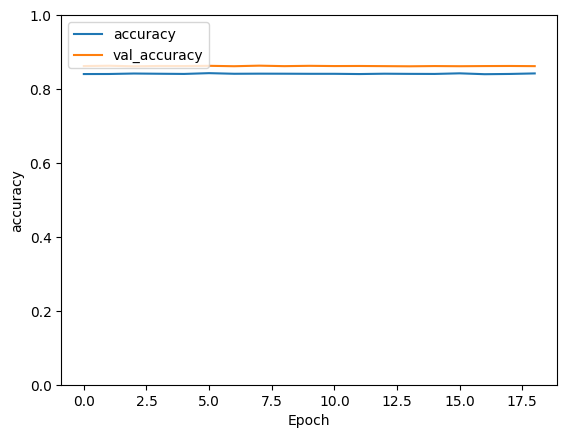

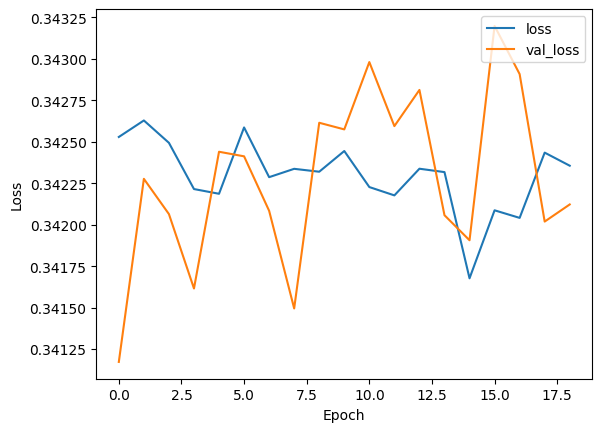

Training fold 9
Found 41453 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1947 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


Found 15430 validated image filenames.
Found 4598 validated image filenames.
Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 224 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


648/648 [==============================] - 139s 215ms/step - loss: 0.3418 - accuracy: 0.8409 - val_loss: 0.3403 - val_accuracy: 0.8599 - lr: 3.9062e-07
Epoch 2/100
648/648 [==============================] - 136s 209ms/step - loss: 0.3419 - accuracy: 0.8407 - val_loss: 0.3410 - val_accuracy: 0.8599 - lr: 3.9062e-07
Epoch 3/100
648/648 [==============================] - 137s 211ms/step - loss: 0.3420 - accuracy: 0.8428 - val_loss: 0.3408 - val_accuracy: 0.8610 - lr: 3.9062e-07
Epoch 4/100
648/648 [==============================] - 162s 251ms/step - loss: 0.3416 - accuracy: 0.8399 - val_loss: 0.3403 - val_accuracy: 0.8606 - lr: 3.9062e-07
Epoch 5/100
648/648 [==============================] - 151s 233ms/step - loss: 0.3424 - accuracy: 0.8406 - val_loss: 0.3404 - val_accuracy: 0.8602 - lr: 3.9062e-07
Epoch 6/100
648/648 [==============================] - 149s 231ms/step - loss: 0.3421 - accuracy: 0.8404 - val_loss: 0.3405 - val_accuracy: 0.8606 - lr: 3.9062e-07
Epoch 7/100
648/648 [=======

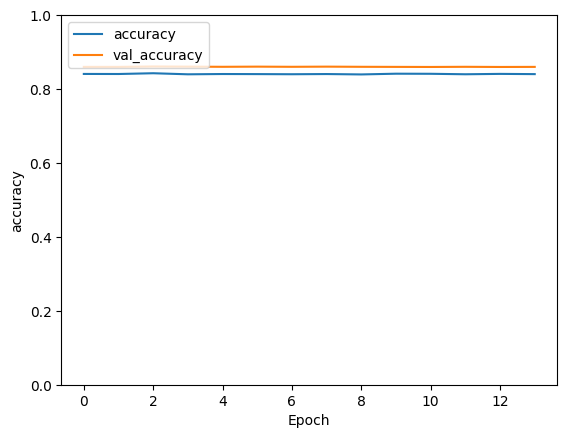

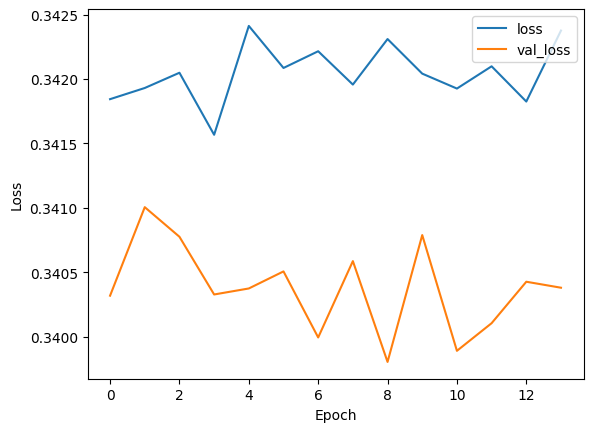

Training fold 10
Found 41429 validated image filenames.
Found 15430 validated image filenames.
Found 4622 validated image filenames.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1971 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 626 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 200 invalid image filename(s) in x_col="ClipID". These filename(s) will be ignored.
  warnings.warn(


Epoch 1/100
648/648 [==============================] - 147s 226ms/step - loss: 0.3422 - accuracy: 0.8420 - val_loss: 0.3402 - val_accuracy: 0.8576 - lr: 1.9531e-07
Epoch 2/100
648/648 [==============================] - 145s 224ms/step - loss: 0.3421 - accuracy: 0.8399 - val_loss: 0.3395 - val_accuracy: 0.8572 - lr: 1.9531e-07
Epoch 3/100
648/648 [==============================] - 145s 224ms/step - loss: 0.3421 - accuracy: 0.8423 - val_loss: 0.3394 - val_accuracy: 0.8581 - lr: 1.9531e-07
Epoch 4/100
648/648 [==============================] - 145s 224ms/step - loss: 0.3421 - accuracy: 0.8420 - val_loss: 0.3398 - val_accuracy: 0.8576 - lr: 1.9531e-07
Epoch 5/100
648/648 [==============================] - 151s 232ms/step - loss: 0.3427 - accuracy: 0.8420 - val_loss: 0.3402 - val_accuracy: 0.8587 - lr: 1.9531e-07
Epoch 6/100
648/648 [==============================] - 146s 226ms/step - loss: 0.3422 - accuracy: 0.8411 - val_loss: 0.3400 - val_accuracy: 0.8585 - lr: 1.9531e-07
Epoch 7/100
648/

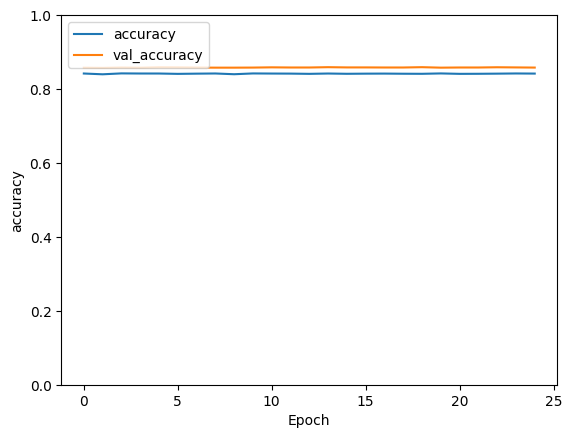

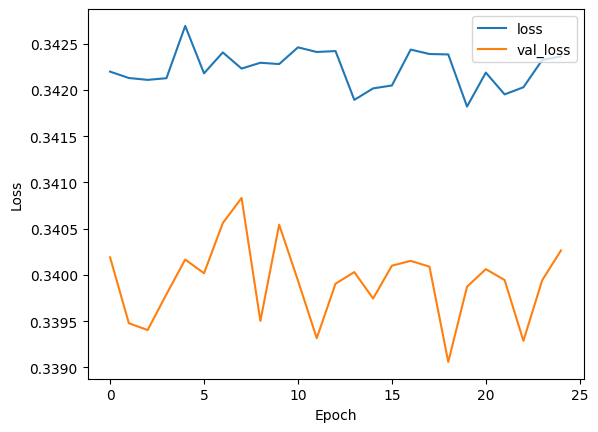

In [96]:
model = model()
model.summary()
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001, clipnorm=1.0), loss='binary_crossentropy', metrics=['accuracy'])

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_df_normalized)):
    print(f"Training fold {fold + 1}")

    train_fold = train_df_normalized.iloc[train_idx]
    val_fold = train_df_normalized.iloc[val_idx]
    
    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_fold,
        x_col='ClipID',
        y_col=['Boredom', 'Engagement', 'Confusion', 'Frustration'],
        target_size=(80, 144),
        batch_size=64,
        class_mode='raw',
        shuffle=True,
        preprocessing_function=augment_image
    )
    
    # images, labels = next(train_generator)
    # plot_images(images, labels, 'Train Images')
    
    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_df_normalized,
        x_col='ClipID',
        y_col=['Boredom', 'Engagement', 'Confusion', 'Frustration'],
        target_size=(80, 144),
        batch_size=64,
        class_mode='raw',
        shuffle=True,
    )
    
    # images, labels = next(test_generator)
    # plot_images(images, labels, 'Test Images')
    
    validation_generator = train_datagen.flow_from_dataframe(
        dataframe=val_fold,
        x_col='ClipID',
        y_col=['Boredom', 'Engagement', 'Confusion', 'Frustration'],
        target_size=(80, 144),
        batch_size=64,
        class_mode='raw',
        shuffle=True,
    )
    
    # images, labels = next(validation_generator)
    # plot_images(images, labels, 'Validation Images')
    
    # Train the model
    history = model.fit(
        train_generator,
        epochs=100,
        validation_data=validation_generator,
        callbacks=callbacks
    )
    
    # Evaluate the model on the test set
    test_images, test_labels = next(test_generator)
    test_predictions = model.predict(test_images)
    test_loss, test_acc = model.evaluate(test_images, test_labels)
    
    print(f'Test accuracy: {test_acc}')
    
    graphs(history)
    
    saveModelWeights(model, test_acc)

In [99]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
 
# graphs(history)

# saveModelWeights(model, test_acc)

2/2 [==============================] - 0s 34ms/step - loss: 0.4345 - accuracy: 0.8125


2/2 [==============================] - 0s 49ms/step
              precision    recall  f1-score   support

     Boredom       0.00      0.00      0.00         8
  Engagement       0.80      0.90      0.85        52
   Confusion       0.00      0.00      0.00         3
 Frustration       0.00      0.00      0.00         1

    accuracy                           0.73        64
   macro avg       0.20      0.23      0.21        64
weighted avg       0.65      0.73      0.69        64


/var/folders/wx/c2fc49pd4s7fq23msz0ypksh0000gn/T/ipykernel_15138/1827476047.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


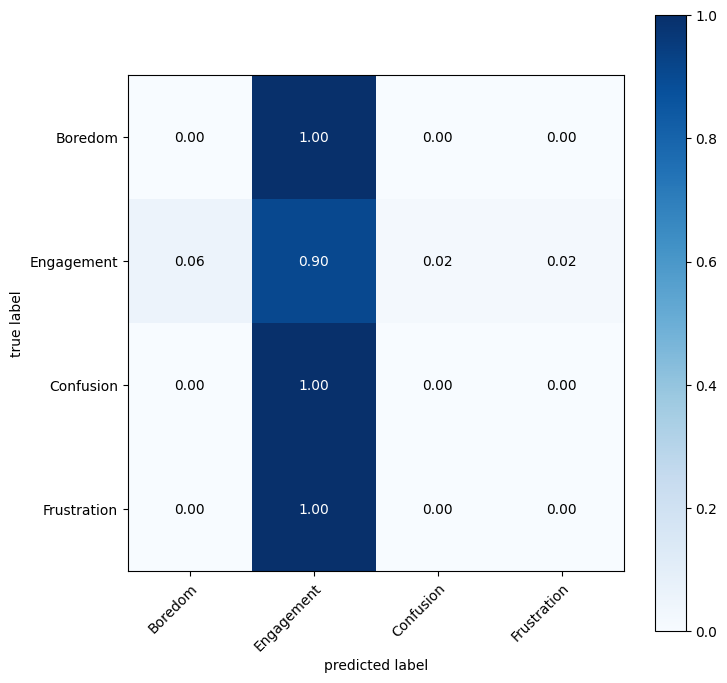

In [11]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report
import numpy as np

pred_test_labels = model.predict(test_images)

conf_mat = confusion_matrix(np.argmax(test_labels, axis=1), np.argmax(pred_test_labels, axis=1))

emotions = {0: 'Boredom', 1: 'Engagement', 2: 'Confusion', 3: 'Frustration'}

#Plot confusion matrix
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                colorbar=True,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()
#Print classifation report
print(classification_report(test_labels.argmax(axis=1), pred_test_labels.argmax(axis=1), target_names=emotions.values()))